In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 1.5
darkgrey = '#3A3A3A'
lightgrey = '#414141'
barblue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
plt.rcParams['text.color'] = darkgrey
plt.rcParams['axes.labelcolor'] = darkgrey
plt.rcParams['xtick.color'] = lightgrey
plt.rcParams['ytick.color'] = lightgrey

# Forecasting Feasible Delivery Date with a Monte Carlo Simulation 'When'
## Context
In our epic planning we decided on 20 items that will deliver the promised value to the customer. Before we make a commitment for a delivery date, we have to forecast when and how likely we will finish this scope.

## Idea

To understand the current delivery capability, we tracked our throughput and cycle times of our items in the issue tracking tool [Jira](https://de.atlassian.com/software/jira). We can use this data to forecast future throughput. 

The measurement took place between 13th July 2018 and 30th January 2019. The results were exported into a CSV file using the [Jira-to-Analytics](https://github.com/ActionableAgile/jira-to-analytics) command line tool with the following configuration:
```
[...]
Criteria:
    Project: 
        - DATA
    Issue types: 
        - Story
        - Task
        - Bug
    Start Date: 2018-07-13
    End Date: 2019-01-30

Workflow:
[...]

```
The CSV file contains all items that were created and moved through during the measurement. We just take the relevant data of completed items: completion date and type

In [3]:
kanban_data = pd.read_csv(
    'data.csv', usecols=['Done', 'Type'], parse_dates=['Done']).dropna()
kanban_data.head(1)

,Done,Type
0,2018-09-26,Story


## Analysis

Based on the past throughput per day a forecast can be created with a Monte Carlo simulation. Throughput is the number of total items completed per day.

### Calculate Throughput
Therefore, we sum up the completed items per day and add the missing dates with zero throughput. We plot the data of the throughput per day to get a brief overview of the result.

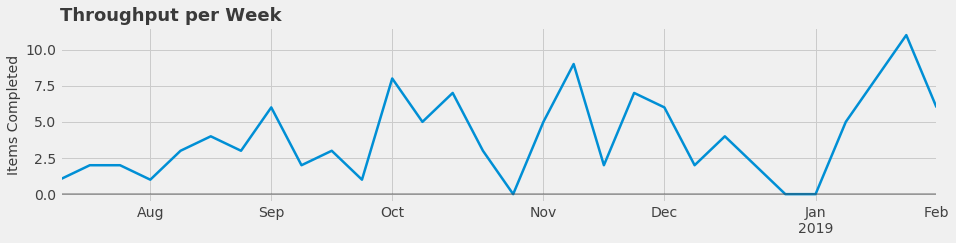

In [4]:
throughput = pd.crosstab(
    kanban_data.Done, kanban_data.Type, colnames=[None]).reset_index()
throughput['Throughput'] = throughput.Bug + throughput.Story + throughput.Task
date_range = pd.date_range(
    start=throughput.Done.min(), end=throughput.Done.max())
throughput = throughput.set_index('Done').reindex(
    date_range).fillna(0).astype(int).rename_axis('Date')
throughput_per_week = pd.DataFrame(
    throughput['Throughput'].resample('W-Mon').sum()).reset_index()
ax = throughput_per_week.plot(
    x='Date', y='Throughput', linewidth=2.5, figsize=(14, 3), legend=None)
ax.set_title("Throughput per Week", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_xlabel('')
ax.set_ylabel('Items Completed')
ax.axhline(y=0, color=lightgrey, alpha=.5);

### Run Monte Carlo Simulation 'When'
Based on the throughput data we simulate multiple times when the number of items will be completed. Before we run the simulation we set the configuration values:
* Date range of data basis (last days)
* Number of items to simulate.
* Start date of work
* Number of simulations to run (Recommendation: >= 10000).

We plot the simulation results to get a brief overview of distribution of completion dates.

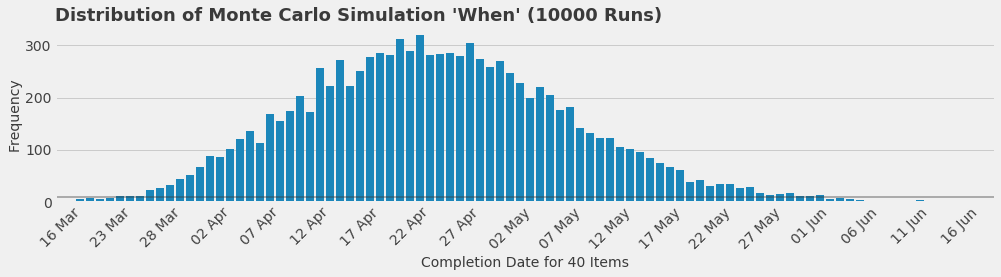

In [5]:
### SETTINGS ####
LAST_DAYS = 100
SIMULATION_ITEMS = 40
START_DATE = pd.to_datetime('2019-02-01')
SIMULATIONS = 10000


def simulate_days(data, scope):
    days = 0
    total = 0
    while total <= scope:
        total += dataset.sample(n=1).iloc[0].Throughput
        days += 1
    completion_date = START_DATE + pd.Timedelta(days, unit='d')
    return completion_date


dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)
samples = [simulate_days(dataset, SIMULATION_ITEMS)
           for i in range(SIMULATIONS)]
samples = pd.DataFrame(samples, columns=['Date'])
distribution = samples.groupby(['Date']).size().reset_index(name='Frequency')

plt.figure(figsize=(15, 3))
ax = sns.barplot(x='Date', y='Frequency', data=distribution, color=barblue)
ax.set_title(f"Distribution of Monte Carlo Simulation 'When' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})
ax.set_xlabel(f"Completion Date for {SIMULATION_ITEMS} Items")
ax.set_ylabel('Frequency')
unique_dates = sorted(list(distribution['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), 5)
ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime('%d %b')
                    for i in date_ticks], rotation=45)
ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5);

### Analysis of the Probabilities of Occurrence
We determine the probability for each number of completed items by cumulating the frequency in the simulations. We plot the probability for each number of completed items and indicate the percentiles 70%, 85%, and 95%.

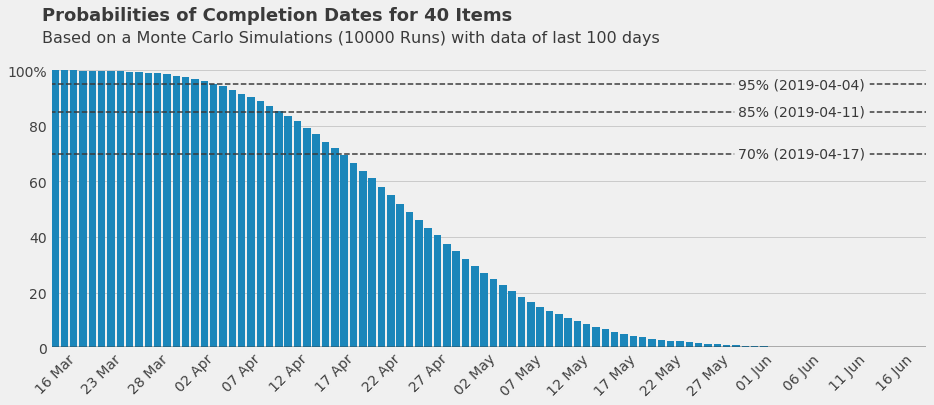

In [6]:
distribution = distribution.sort_index(ascending=False)
distribution['Probability'] = 100 * \
    distribution.Frequency.cumsum()/distribution.Frequency.sum()
plt.figure(figsize=(14, 5))
ax = sns.barplot(x='Date', y='Probability', data=distribution, color=barblue)
ax.text(x=-1.4, y=118,
        s=f"Probabilities of Completion Dates for {SIMULATION_ITEMS} Items", fontsize=18, fontweight='semibold')
ax.text(x=-1.4, y=110,
        s=f"Based on a Monte Carlo Simulations ({SIMULATIONS} Runs) with data of last {LAST_DAYS} days", fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')
ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=70, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')
label_xpos = distribution['Date'].max() - pd.Timedelta(30, unit='d')
ax.text(y=70, x=80, s=f"70% ({samples.Date.quantile(0.3).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=80, s=f"85% ({samples.Date.quantile(0.15).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=80, s=f"95% ({samples.Date.quantile(0.05).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%'])

unique_dates = sorted(list(distribution['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), 5)
ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime('%d %b')
                    for i in date_ticks], rotation=45);

## Conclusion
A delivery date before 17th April 2019 will be risky when we start on 1st February 2019. Therefore, a delivery date past this date should be chosen.